# CESM-LE analysis
### Looks and changes in Fire risk over time
 - reading in ensemble of data from CESM2_LENS
 - here, looking at daily TBOT, RH, & precip
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os

import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import cartopy.crs as ccrs

import numba
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from tqdm.auto import tqdm
from distributed import wait
import FWI_Wang2015 as fwi  # Jackie's python script

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### run this cell to check if you have LENS2 read access:

In [2]:
samplefile = (
    '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'
    + 'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc'
)
cmd = 'stat ' + samplefile
if os.system(cmd) != 0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [3]:
# For use on Casper: ONLY RUN THIS CELL ONCE
# note you may need to change the project number
# Anderson recommended "Reduce the number of dask-workers (from 36 to 18)
#    to allow dask to allocate more memory to each worker"
ncores = 10
nmem = str(int(400 * ncores / ncores)) + 'GB'
from dask.distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster(
    cores=ncores,
    processes=ncores,
    memory=nmem,
    #project='P93300641',
    walltime='1:00:00',
    extra=["--lifetime", "55m", "--lifetime-stagger", "4m"],
)
# cluster.scale(ncores)
cluster.adapt(minimum_jobs=7, maximum_jobs=7)  # change to 9 w/ 50 ens members
client = Client(cluster)

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33797 instead
  warnings.warn(


In [4]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
cluster

# If not running, check the following on command line
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`

In [5]:
#cluster.close()
#client.restart()
#client

### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [5]:
def get_members(model):
    members = []
    if model =='CESM1':
        members = [str(i).zfill(3) for i in [*(1+np.arange(35)),*(101+np.arange(7))]]
    else:
        for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
            s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
            members.append(s)
        for i in [1231,1251,1281,1301]:
            for j in 1+np.arange(10):
                s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
                members.append(s)
    return members

In [6]:
def file_dict(model,mem,field,component,hist=True,freq='monthly'):
    ''' returns a dictionary of filepaths keyed by year, for a given ensemble member '''
    mm = get_members(model)[mem]
    filepaths = {}
    
    if model=='CESM1':
        #detailing the directory structure
        topdir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+ \
                  component+'/proc/tseries/'
        if freq =='monthly': 
            freq = 'monthly/'
            tape = '.h0.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'
        if hist: runtype = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        else:    runtype = 'b.e11.BRCP85C5CNBDRD.f09_g16.'
        #find all the relevant files
        files = glob.glob(thisdir+runtype+'*'+tape+field+'*')
    else:
        #detailing the directory structure
        topdir  = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        ATM     = '/atm/proc/tseries/'
        LND     = '/lnd/proc/tseries/'
        if hist: runtype = 'b.e21.BHISTcmip6.f09_g17.'
        else:    runtype = 'b.e21.BSSP370cmip6.f09_g17.'
        if freq=='monthly':
            freq    = 'month_1/'
            tape    = '.h0.'
        elif freq=='daily':
            freq    = 'day_1/'
            if component == 'lnd': tape    = '.h5.'
            if component == 'atm': tape    = '.h1.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        if component == 'lnd':
            thisdir = topdir+runtype+mm+LND+freq
        if component == 'atm':
            thisdir = topdir+runtype+mm+ATM+freq

        #find all the relevant files
        files = glob.glob(thisdir+'*'+tape+field+'.*')

    for file in files:
        #isolate y1 and y2 from the file name
        ystr = file.split(field)[-1]
        y1 = int(ystr[1:5])
        ystr = ystr.split('-')[1]
        y2 = int(ystr[0:4])
        for yy in np.arange(y1,y2+1):
            filepaths[yy]=file
        
    return filepaths

In [7]:
def get_file(model,mem,field,year,component,freq='monthly'):
    ''' get a single file for the given model-mem-field-year'''
    hist = True
    if model=='CESM1' and year>2005: hist=False
    if model=='CESM2' and year>2014: hist=False

    filepaths = file_dict(model,mem,field,hist,component,freq)

    if year in filepaths.keys():
        file = filepaths[year]
    else:
        print('file not found for that member')
        file = []
    
    return file

In [8]:
def all_files(model,ens,field,firstyear,lastyear, component,\
              freq='monthly'):
    ''' retrieve a list of files containing the given ensemble'''
    ens = np.array(ens)
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        file0 = ''
        first = True
        for yr in yrs:
            #fetch filepaths
            if first:
                hist = True
                if model=='CESM1' and yr>2005: hist=False
                if model=='CESM2' and yr>2014: hist=False
                filepaths = file_dict(model,ee,field,component,hist,freq)
                first     = False  
            #append file if it is new
            if yr in filepaths.keys():
                file = filepaths[yr]
                if file != file0:
                    ffs.append(file)
                    file0 = file

            #trigger new filepaths fetch when needed
            if model=='CESM1' and yr==2005: first=True
            if model=='CESM2' and yr==2014: first=True

        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [10]:
def preprocess(ds):
    variables = {"RAIN", "SNOW", "TREFHT", "RHREFHT", "WSPDSRFAV", "TREFHTMX", "PPT"}
    x = list(set(ds.data_vars).difference(variables))
    for v in x:
        ds = ds.set_coords(v)
        ds[v].load()
    return ds

In [9]:
def get_data(model,ens,fields,firstyear,lastyear,component,freq, \
             chunks={'time':1000}):
    ''' returns an xarray dataset containing the requested ensemble
    model = \'CESM1\' or \'CESM2\'
    ens   = list of members, via simple sequential key e.g. range(50) gets the first 50 members
            [0,2,4] would get the first, third, and fifth ensemble members (see get_members)
    fields = list of desired fields, you do not need to ask for lat/lon/time
    firstyear = int [1850-2100]
    lastyear  = int [1850-2100]
    freq = \'monthly\' or \'daily\' '''

    ds = xr.Dataset()    #instantiate Dataset

    #allow for single field or list of fields
    if type(fields)==str: fields=[fields]  
    
    #add fields one at a time to the dataset
    for field in fields:
        files,ens = all_files(model,ens,field,firstyear,lastyear,component,freq)
        ensdim  = xr.DataArray(ens, dims='ens', name='ens')
        dims    = [ensdim,'time']
        # check if all members have the same number of files (not guaranteed)
        nfs = np.array([len(ffs) for ffs in files])
        if np.sum(nfs==nfs[0])==len(nfs):
            one_go=True   # same number of files
        else:
            one_go=False
        if one_go: #read all data in one go
            tmp = xr.open_mfdataset(files,combine='nested',
                                    parallel=True,
                                    concat_dim=dims,
                                    chunks=chunks,
                                    preprocess=preprocess)
            tmp = preprocess(tmp)
        else:      #read data one member at a time and then concat
            print("not one go.")
            dsets = []
            for ffs in files:
                d0 = xr.open_mfdataset(ffs,combine='nested',
                                       parallel=True,
                                       concat_dim=['time'],
                                       chunks=chunks,
                                       preprocess=preprocess)
                d0 = preprocess(d0)
                dsets.append(d0)
            # <---- CHANGED: THIS MADE A GIANT DIFFERENCE
            tmp = xr.concat(dsets,dim=ensdim, 
                            #coords="minimal", compat="override"
                           )
        ds[field] = tmp[field]

    #grab one copy of the various extra variables, e.g. landfrac,area
    tmp = xr.open_dataset(files[0][0])
    tmp = preprocess(tmp)
    
    for thisvar in tmp.data_vars:
        if 'time' not in tmp[thisvar].coords:
            ds[thisvar]=tmp[thisvar]

    # quick fix to adjust time vector for monthly data        
    if freq=='monthly':
        nmonths = len(ds.time)
        yr0 = ds['time.year'][0].values
        ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

    return ds.sel(time=slice(str(firstyear),str(lastyear)))

In [11]:
def get_landarea(model):
    file= get_file(model,0,'GPP',1990)
    ds = xr.open_dataset(file)
    la = ds['area']*ds['landfrac']
    return la

In [12]:
def month_wts(nyears):
    days_pm = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    return xr.DataArray(np.tile(days_pm, nyears), dims='time')

------------
# Start editing here:

### Actually read the data

In [ ]:
%%time

lnd_vars = ['RAIN', 'SNOW']
model = 'CESM2'
firstyear = 1850
lastyear  = 1900
freq      = 'daily'

component = 'lnd'
ens = 10+np.arange(2)
nens = len(ens)
ds = get_data(model,ens,lnd_vars,firstyear,lastyear,
              component,freq, chunks=chunks) #.persist()
_ = wait(ds)
print('lnd read in')

atm_vars = ['TREFHT', 'RHREFHT', 'WSPDSRFAV', 'TREFHTMX'] 
component = 'atm'
ds_atm = get_data(model,ens,atm_vars,firstyear,lastyear,
                  component,freq, chunks=chunks) #.persist()
_ = wait(ds_atm)
print('atm read in')

- 3 ensembles = 500 GB data!
- 10 ens = 1.2 TB, too large for 70 workers

In [ ]:
# force coordinate variables to match
ds_atm["lat"] = ds["lat"]
ds_atm["lon"] = ds["lon"]


ds.update(ds_atm[atm_vars])  # <---- CHANGED
# for i in range(len(atm_vars)):
#    ds[atm_vars[i]] = ds_atm[atm_vars[i]]

# ds = client.persist(ds)
# _ = wait(ds)
del ds_atm

ds[atm_vars[0]].isel(ens=0, time=0).plot()
ds.nbytes / 1e9  # GB

In [ ]:
# sum rain + snow for precip.
s2d = 3600 * 24  # convert from sec to day
ds['PPT'] = (ds['RAIN'] + ds['SNOW']) * s2d
ds.PPT.attrs['units'] = 'mm/d'
ds.PPT.attrs['long_name'] = 'Total Precip.'

# set max RH, used fire weather calculation...
ds["RHREFHT"] = ds.RHREFHT.clip(max=100) # <--- CHANGED
# ds['RHREFHT'] = ds.RHREFHT.where(ds.RHREFHT < 100, 100)

# mask out oceans for temp and RH
# ds = ds.where(ds['PPT'].max(['time', 'ens']) > 0.0)
ds = ds.where(ds.landmask.notnull())  # <------ CHANGED
ds['RHREFHT'].isel(time=0, ens=0).plot(robust=True);

In [33]:
#del ds.RAIN
#del ds.SNOW

In [ ]:
%%time
# convert units as needed
ds['TREFHT'] = ds['TREFHT'] - 273.15  # convert to degC
ds['TREFHTMX'] = ds['TREFHTMX'] - 273.15  # convert to degC
ds['rh'] = ds['RHREFHT'] / 100  # convert to fraction
ds['WSPDSRFAV'] = ds['WSPDSRFAV'] * 3600 * 1e-3  #  m/s to km/h
ds['TREFHT'].attrs['units'] = 'degC'
ds['TREFHTMX'].attrs['units'] = 'degC'
ds['WSPDSRFAV'].attrs['units'] = 'km/h'

ds = ds.rename({'TREFHT':'temp', 'TREFHTMX':'tmax','WSPDSRFAV':'wind'})
# mask out missing values (again) & compute data
ds = ds.where(ds.landmask.notnull())  
#ds = client.persist(ds)
#_ = wait(ds)

In [25]:
del ds['RAIN']
del ds['SNOW']
ds

,Array,Chunk
Bytes,8.23 GB,221.18 MB
Shape,"(2, 18615, 192, 288)","(1, 1000, 192, 288)"
Count,336 Tasks,42 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,8.23 GB,221.18 MB
Shape,"(2, 18615, 192, 288)","(1, 1000, 192, 288)"
Count,336 Tasks,42 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


--------------
## Calculate Nesterov Fire Danger Index
- acc_NI is the accumulated Nesterov fire danger index, which resets w/ daily precip > 3 mm 
- d_NI is the daily Nesterov fire danger index, calculated from temp, precip & RH
- from https://github.com/NGEET/fates/blob/master/fire/SFMainMod.F90

  - temp  = TREFHT (in C)
  - ppt   = PPT*sec_per_day (mm)
  - rh    = RHREFHT (fraction)
   
Nesterov Fire danger Index code in FATES: https://github.com/NGEET/fates/blob/8827a6ea77f0e4f5d8408ddd7eeaa776bb3bba8a/fire/SFMainMod.F90#L116-L162


In [ ]:
%%time
# these are the calculations that take forever!
# maybe it's not worth loading thse intermediate calculations into memory?

# Fates_fire constants
# Nesterov from EQ 5 Thonicke et al 2010:
fdi_a = 17.62
fdi_b = 243.12

yipsolon = (fdi_a * ds.temp) / (fdi_b + ds.temp) + np.log(ds.rh)

# Standard met. formula
dewpoint = (fdi_b * yipsolon) / (fdi_a - yipsolon)

# follows Nesterov 1968.  Equation 5. Thonicke et al. 2010.
ds['d_NI'] = (ds.temp - dewpoint) * ds.temp  # .compute(skipna=True)

# don't allow negative values
ds['d_NI'] = ds['d_NI'].clip(min=0)

# Reset when daily precip > 3 mm/day
ds['d_NI'] = ds['d_NI'].where(ds.PPT < 3, np.nan)  # .compute(skipna=True)
ds['d_NI'].isel(ens=0, time=300).plot() ;

### Accumulate Nesterov index over the fire season
####  Reset when daily precip > 3 mm/day (set d_NI to nan) 

In [107]:
# faster to select grid here
plat, plon, site = -13 , 307.5, 'Amazon'
#plat, plon, site = 66.4, 209  , 'Alaska'
#plat, plon, site = 39  , 253  , 'Crested Butte'
# 40, 270

In [91]:
# reset cumulative sum when nan crossed in dataset
# pandas examples here https://stackoverflow.com/questions/18196811/cumsum-reset-at-nan seems to work,
#    not so much for the numpy example...

# This is prohibitively slow with longer TS... let's not do it

# define function that calculates cumulative sum of d_NI that resets when nan
'''def runningSum(dIN):
    # make array to hold data
    result = dIN.copy()

    # loop over ens
    ## Can we avoind the ens loop here?
    for i in range(len(result[:])):
        v = pd.Series(dIN[i])
        cumsum = v.cumsum().fillna(method='pad')
        reset = -cumsum[v.isnull()].diff().fillna(cumsum)
        result[i, :] = v.where(v.notnull(), reset).cumsum()

    return result'''

"def runningSum(dIN):\n    # make array to hold data\n    result = dIN.copy()\n\n    # loop over ens\n    ## Can we avoind the ens loop here?\n    for i in range(len(result[:])):\n        v = pd.Series(dIN[i])\n        cumsum = v.cumsum().fillna(method='pad')\n        reset = -cumsum[v.isnull()].diff().fillna(cumsum)\n        result[i, :] = v.where(v.notnull(), reset).cumsum()\n\n    return result"

In [24]:
# test for a single grid
# data must be loaded into memory to work in the function above

#tempIn = ds['d_NI'].sel(lon=plon, lat=plat, method='nearest').copy(deep=True).load()
#%%time
#temp = runningSum(tempIn)
#plt.plot(temp[0, :]) ;

In [116]:
def running_sum_np(data):
    v = pd.Series(data.copy())
    cumsum = v.cumsum().fillna(method='pad')
    reset = -cumsum[v.isnull()].diff().fillna(cumsum)
    result = v.where(v.notnull(), reset).cumsum()
    return result.values

In [26]:
#%%time
#temp2 = running_sum_np(tempIn.isel(ens=0))
#plt.plot(temp2) ;
#del acc_NI

### Now try over full grid

~~Must load into memory first~~ 


In [123]:
# use apply_ufunc to broadcast running_sum_1d function globally
# Make sure the input dataset isn't chunked along the core `time` dimension
input_ds = ds.d_NI.chunk({'time': -1, 'lat':50,'lon':50})
input_ds = input_ds.transpose('ens','lat','lon','time')
print(input_ds)

acc_NI = xr.apply_ufunc(
    running_sum_np,
    input_ds,
    input_core_dims=[['time']],
    output_core_dims=[["time"]],
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
    output_dtypes=[ds.d_NI.dtype],
)


<xarray.DataArray 'd_NI' (ens: 3, lat: 192, lon: 288, time: 18615)>
dask.array<transpose, shape=(3, 192, 288, 18615), dtype=float32, chunksize=(1, 50, 50, 18615), chunktype=numpy.ndarray>
Coordinates: (12/34)
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat           (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    area          (lat, lon) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    landfrac      (lat, lon) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    landmask      (lat, lon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    pftmask       (lat, lon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    ...            ...
    ch4vmr        (time) float64 dask.array<chunksize=(18615,), meta=np.ndarray>
    n2ovmr        (time) float64 dask.array<chunksize=(18615,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(18615,), meta=np.ndarray>
    f12vmr        (time) fl

In [124]:
%%time
acc_NI = client.persist(acc_NI, retries=3)
_ = wait(acc_NI)
# get back orig. chunk sizes
#acc_NI = acc_NI.chunk({'time': 1000, 'lat':192,'lon':288})

tornado.application - ERROR - Uncaught exception GET /individual-workers/ws (::1)
HTTPServerRequest(protocol='http', host='localhost:9998', method='GET', uri='/individual-workers/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/tornado/websocket.py", line 956, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/tornado/web.py", line 3178, in wrapper
    return method(self, *args, **kwargs)
  File "/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/bokeh/server/views/ws.py", line 137, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/di

KeyboardInterrupt: 

Can the step above be done more efficiently? 

Quick look at data below...

In [ ]:
# this is inefficient now that you've chunked back to big chunks
temp = acc_NI.sel(lat=plat, lon=plon, method='nearest')
temp.plot(hue='ens') ;

## NI Fire Risk classification
* 0-300 minimal danger
* to 1000 moderate
* to 4000 high
* above 4000 extreme

In [120]:
%%time
# Ensemble mean of days / year with extreme fire risk

# <--- changed. resample() is sort of slow, so only doit once and reuse the resample object
count_base = acc_NI.where(acc_NI > 4000).resample(time="Y").count(dim="time")

# skipna applies to reductions , so pass it to mean.
# skipna is True by default, so could be removed.
exCount = count_base.mean(dim="ens", skipna=True).compute()
print("finished exCount mean")

exCountstd = count_base.std(dim="ens", skipna=True).compute()

KeyboardInterrupt: 

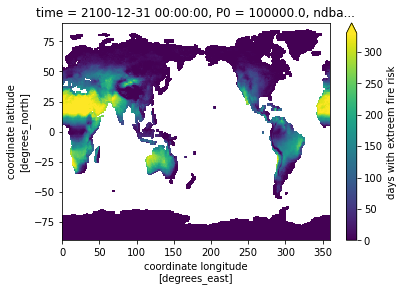

In [34]:
# removed ocean masking
exCount.isel(time=-1).plot(
    robust=True, cbar_kwargs={"label": "days with extreem fire risk"}
);

## Change days with in extreme fire risk 

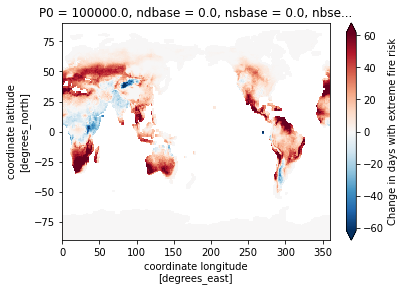

In [35]:
(exCount.isel(time=slice(-10,None)).mean('time') - 
 exCount.isel(time=slice(  0, 10 )).mean('time')) \
  .where(ds['PPT'].max(['time', 'ens']) > 0) \
  .plot(robust=True, 
        cbar_kwargs={"label": "Change in days with extreme fire risk"}) ;

Text(0.5, 1.0, '')

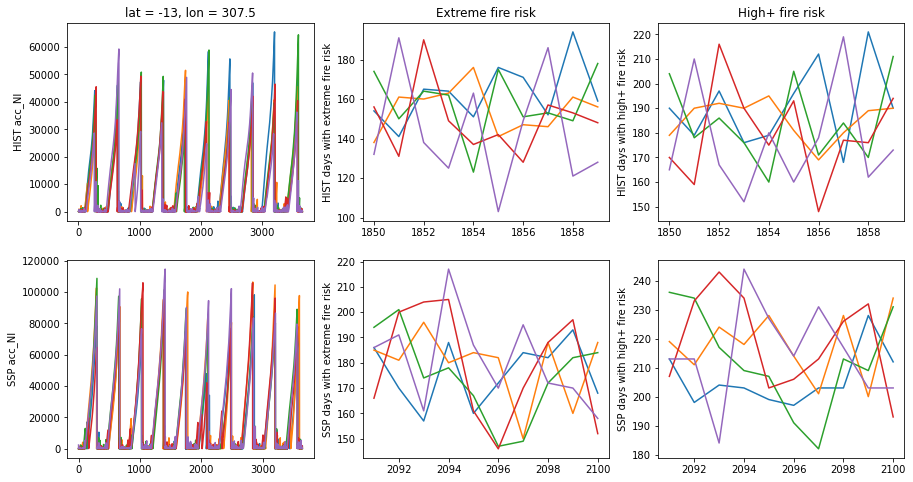

In [36]:
plt.figure(figsize=[15, 8])
plt.subplot(2, 3, 1)
plt.plot(temp.isel(time=slice(0,3650)) \
             .transpose('time', 'ens'))
plt.title('lat = ' + str(plat) + ', lon = ' + str(plon))
plt.ylabel('HIST acc_NI')
plt.xlabel('')

plt.subplot(2, 3, 2)
exCount = temp.where(temp > 4000) \
              .isel(time=slice(0,3650)) \
              .groupby('time.year').count(dim='time')
exCount.plot(hue='ens', add_legend=False)
plt.ylabel('HIST days with extreme fire risk')
plt.xlabel('')
plt.title('Extreme fire risk')

plt.subplot(2, 3, 3)
hiCount = temp.where(temp > 1000) \
              .isel(time=slice(0,3650)) \
              .groupby('time.year').count(dim='time')
hiCount.plot(hue='ens', add_legend=False)
plt.ylabel('HIST days with high+ fire risk')
plt.xlabel('')
plt.title('High+ fire risk')

plt.subplot(2, 3, 4)
plt.plot(temp.isel(time=slice(-3650,None)) \
             .transpose('time', 'ens'))
plt.title('')
plt.ylabel('SSP acc_NI')
plt.xlabel('')

plt.subplot(2, 3, 5)
exCount = temp.where(temp > 4000) \
              .isel(time=slice(-3650,None)) \
              .groupby('time.year').count(dim='time')
exCount.plot(hue='ens', add_legend=False)
plt.ylabel('SSP days with extreme fire risk')
plt.xlabel('')
plt.title('')

plt.subplot(2, 3, 6)
hiCount = temp.where(temp > 1000) \
              .isel(time=slice(-3650,None)) \
              .groupby('time.year').count(dim='time')
hiCount.plot(hue='ens', add_legend=False)
plt.ylabel('SSP days with high+ fire risk')
plt.xlabel('')
plt.title('')

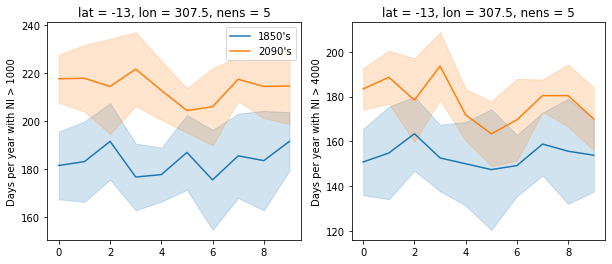

In [37]:
plt.figure(figsize=[10, 4])
minRisk = [1000, 4000]
for i in range(2):
    exCount_HIST = (
        temp.where(temp > minRisk[i]) \
            .isel(time=slice(0,3650)) \
            .groupby('time.year').count(dim='time').mean(dim='ens')
    )
    exCount_HISTsd = (
        temp.where(temp > minRisk[i]) \
            .isel(time=slice(0,3650)) \
            .groupby('time.year').count(dim='time').std(dim='ens')
    )
    exCount_SSP = (
        temp.where(temp > minRisk[i]) \
               .isel(time=slice(-3650,None)) \
               .groupby('time.year').count(dim='time').mean(dim='ens')
    )
    exCount_SSPsd = (
        temp.where(temp > minRisk[i]) \
               .isel(time=slice(-3650,None)) \
               .groupby('time.year').count(dim='time').std(dim='ens')
    )
    x1 = range(len(exCount_HIST.year))
    x2 = range(len(exCount_SSP.year))
    plt.subplot(1, 2, (i + 1))
    plt.plot(x1, exCount_HIST)
    plt.plot(x2, exCount_SSP)
    plt.fill_between(
        x1,
        exCount_HIST - exCount_HISTsd,
        exCount_HIST + exCount_HISTsd,
        alpha=0.2,
        color='tab:blue',
    )
    plt.fill_between(
        x2, exCount_SSP - exCount_SSPsd, exCount_SSP + exCount_SSPsd, alpha=0.2, color='tab:orange'
    )
    plt.title('lat = ' + str(plat) + ', lon = ' + str(plon) + ', nens = ' + str(nens))
    plt.ylabel('Days per year with NI > ' + str(minRisk[i]))
    if i == 0:
        plt.legend(["1850's", "2090's"])
# plt.plot(exCount_SSP)

### Accumulated Nesterov fire danger index shows 
- increases in the number of days per year with high or extreme fire danger in 2100, relative to 2000, 
- better to just plot the whole time seires...
- check for statistical significance

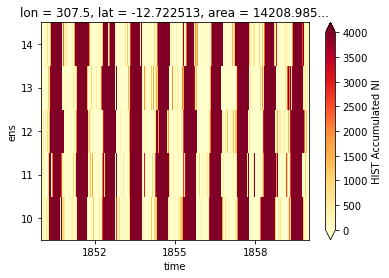

In [40]:
temp.isel(time=slice(0,3650)).plot(
    robust=True, cmap='YlOrRd', vmax=4000, vmin=0, 
    cbar_kwargs={"label": "HIST Accumulated NI"}
) ;

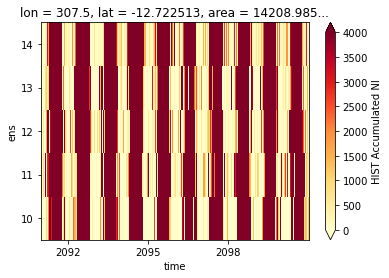

In [41]:
temp.isel(time=slice(-3650,None)).plot(
    robust=True, cmap='YlOrRd', vmax=4000, vmin=0, 
    cbar_kwargs={"label": "HIST Accumulated NI"}
);

- Maybe better illustrates seaonal cycle of fire risk? 
- Appears to have greater variability by 2100!

-----------------------
# Canadian fire weather model
### based on temp, wind, RH, precip & adjusted for monthly day length by latitude
- **fine fuel mositure code (ffmc)**: calc_ffmc(tempC, wind_kmhr, RH, precip_mm, ffmc_prev):
- **duff moisture code (dmc)**: calc_dmc(tmaxC, RH, precip_mm, dmc_prev, month, latitude):
- **drought code (dc)**: calc_dc(tmaxC, precip_mm, dc_prev, month, latitude):
- **initial spread index (isi)**: calc_isi(wind_kmhr,ffmc):
- **build up index (bui)**: calc_bui(dmc,dc):
- **fire weather index (fwi)**: calc_fwi(isi,bui) 

In [36]:
plat, plon, site = 66.4, 209 , 'Alaska'
#plat, plon, site = 39  , 253 , 'Crested Butte'
#plat, plon, site =-13  ,307.5, 'Amazon'
tempDS = ds.sel(ens=0, lon=plon, lat=plat, method='nearest') \
    .isel(time=slice(0,3650)).load()

In [37]:
# tempDS.tmax.values[0]
fwi.calc_ffmc(
    tempDS.tmax.values[3], tempDS.wind.values[3], tempDS.rh.values[3], tempDS.PPT.values[3], 80
)

83.1298255567128

In [38]:
fwi.calc_dmc(
    tempDS.tmax.values[1], tempDS.rh.values[1], tempDS.PPT.values[1], 6., tempDS['time.month'][1],tempDS.lat
)

6.0

In [45]:
# Modify chunks and create new arrays for model output

#ds = ds.chunk({'time':-1,'lat':50,'lon':50})
FWIvars = ['ffmc', 'dmc', 'dc', 'isi', 'bui', 'fwi']
FWIlong = ['fine fuel mositure code','duff moisture code',
           'drought code','initial spread index',
           'build up index','fire weather index']
for v in range(len(FWIvars)):
    ds[FWIvars[v]] = (ds.tmax*0.).persist()
    ds[FWIvars[v]].attrs['long_name'] = FWIlong[v]

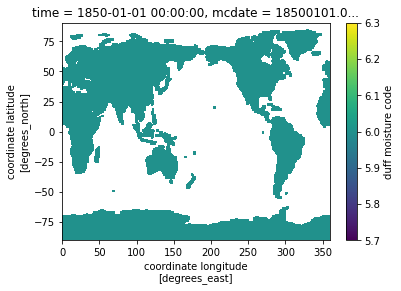

In [63]:
#Set some initial values
ds['ffmc'] = ds['ffmc'].where(ds.time>ds.time[0],80.) \
    .where(ds['PPT'].max(['time', 'ens']) > 0.0)
ds['dmc'] = ds['dmc'].where(ds.time>ds.time[0],6.) \
    .where(ds['PPT'].max(['time', 'ens']) > 0.0)
ds['dc'] = ds['dc'].where(ds.time>ds.time[0],16.) \
    .where(ds['PPT'].max(['time', 'ens']) > 0.0)
ds['dmc'].isel(time=0,ens=0).plot() ;


### I'm totally confused about how to feed the sample calculation into a function for global calculations


In [64]:
ds = ds.persist()  #go ahead and persist ds for calculations
_ = wait(ds)

<xarray.DataArray 'month' (ens: 2, lat: 192, lon: 288)>
dask.array<where, shape=(2, 192, 288), dtype=float64, chunksize=(2, 192, 288), chunktype=numpy.ndarray>
Coordinates: (12/32)
  * ens       (ens) int64 10 11
  * lat       (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    time      object 1850-01-02 00:00:00
    mcdate    float64 1.85e+07
    mcsec     float64 0.0
    ...        ...
    area      (lat, lon) float32 29.95 29.95 29.95 29.95 ... nan nan nan nan
    landfrac  (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    landmask  (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    pftmask   (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    nbedrock  (lat, lon) float64 20.0 20.0 20.0 20.0 20.0 ... nan nan nan nan
    gw        (lat) float64 3.382e-05 0.0002705 0.000541 ... 0.0002705 3.382e-05

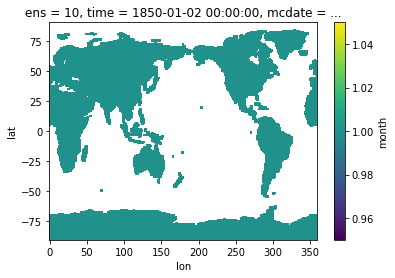

In [132]:
i = 1

exMonth = ds['time.month'].isel(time=i).expand_dims({'ens':ds.ens,'lat':ds.lat,'lon':ds.lon}) \
    .astype('int') \
    .where(ds['PPT'].max(['time', 'ens']) > 0.0)
exLat = ds['lat'].expand_dims({'ens':ds.ens,'lon':ds.lon}) \
    .where(ds['PPT'].max(['time', 'ens']) > 0.0)
#exLat.isel(ens=0).plot(x='lon') ;
exMonth.isel(ens=0).plot(x='lon') ;
#ds['time.month'].expand_dims(ds.tmax.isel(time=i).dims)
#ds.dmc.isel(time=(i-1)).isel(ens=1).plot()
exMonth

In [133]:
ds['ffmc'].data[:,1,:,:]

dask.array<getitem, shape=(2, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>

In [141]:
# for i in tqdm(range(1,len(ds.time))):
i = 1
# calc_ffmc(tempC, wind_kmhr, RH, precip_mm, ffmc_prev):
exMonth = ds['time.month'].isel(time=i).expand_dims({'ens':ds.ens,'lat':ds.lat,'lon':ds.lon}) \
    .astype('int') \
    .where(ds['PPT'].max(['time', 'ens']) > 0.0)
temp_ffmc = xr.apply_ufunc(
    fwi.calc_ffmc,
    ds.tmax.isel(time=i),
    ds.wind.isel(time=i),
    ds.RHREFHT.isel(time=i),
    ds.PPT.isel(time=i),
    ds.ffmc.isel(time=(i-1)),
    #input_core_dims=[['ens']],
    #output_core_dims=[["ens"]],
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
    output_dtypes=['float32'],
).rename(FWIlong[0])

# calc_dmc(tmaxC, RH, precip_mm, dmc_prev, month, latitude):
temp_dmc = xr.apply_ufunc( 
    fwi.calc_dmc,
    ds.tmax.isel(time=i),
    ds.RHREFHT.isel(time=i),
    ds.PPT.isel(time=i),
    ds.dmc.isel(time=(i-1)),
    exMonth,    
    exLat,
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
    output_dtypes=['float32'],
).rename(FWIlong[1])

# calc_dc(tmaxC, precip_mm, dc_prev, month, latitude):
temp_dc = xr.apply_ufunc( 
    fwi.calc_dc,
    ds.tmax.isel(time=i), 
    ds.PPT.isel(time=i),
    ds.dc.isel(time=(i-1)),
    exMonth,    
    exLat,
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
    output_dtypes=['float32'],
).rename(FWIlong[2])


## Why doesn't it work to write over the values here?
ds['ffmc'].isel(time=i).data = temp_ffmc.values
#ds['dmc'].isel(time=i).values = temp_dmc
ds['dc'].isel(time=i).data = temp_dc.values


# do these need to be applied in the same time loop?
'''
# calc_isi(wind_kmhr,ffmc):
temp_isi = xr.apply_ufunc( 
    fwi.calc_isi,
    ds.wind.isel(time=i), 
    ds.ffmc,isel(time=i),
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
    output_dtypes=['float32'],
)
    
# calc_bui(dmc,dc):
temp_bui = xr.apply_ufunc( 
    fwi.calc_bui,
    ds.dmc, 
    ds.dc,
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
    output_dtypes=['float32'],
)

# calc_fwi(isi,bui):
temp_fwi = xr.apply_ufunc( 
    fwi.calc_fwi,
    ds.isi, 
    ds.bui,
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
    output_dtypes=['float32'],
)

'''
print('done!')

done!


Why doesn't it work to write over output correctly?

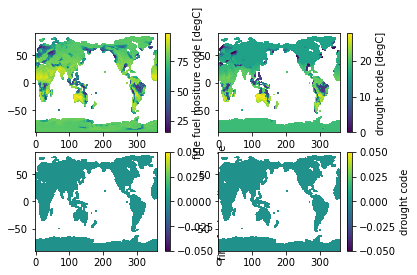

In [143]:
plt.subplot(2,2,1)
temp_ffmc.isel(ens=0).plot() ;
plt.title('')
plt.ylabel('')
plt.xlabel('')

plt.subplot(2,2,2)
temp_dc.isel(ens=0).plot() 
plt.xlabel('')
plt.ylabel('')
plt.title('')

plt.subplot(2,2,3)
ds['ffmc'].isel(time=i, ens=0).plot() 
plt.xlabel('')
plt.ylabel('')
plt.title('')

plt.subplot(2,2,4)
ds['dc'].isel(time=i, ens=0).plot() 
plt.xlabel('')
plt.ylabel('')
plt.title('') ;

In [ ]:
temp_dmc.isel(ens=0).plot() 


In [114]:
# create arrays to store output
FWIvars = ['ffmc', 'dmc', 'dc', 'isi', 'bui', 'fwi']
for v in range(len(FWIvars)):
    tempDS[FWIvars[v]] = xr.DataArray(np.nan, coords=tempDS.tmax.coords)

# loop over days to calculte FWI
for i in tqdm(range(len(tempDS.tmax))):
    # set initial values for
    if i == 0:
        ffmc_prev, dmc_prev,dc_prev = 80, 6,16
    else:
        ffmc_prev = tempDS['ffmc'].data[i - 1]
        dmc_prev  = tempDS['dmc'].data[i - 1]
        dc_prev   = tempDS['dc'].data[i - 1]

    # calc_ffmc(tempC, wind_kmhr, RH, precip_mm, ffmc_prev):
    tempDS.ffmc[i] = fwi.calc_ffmc(
        tempDS.tmax.data[i],
        tempDS.wind.data[i],
        tempDS.RHREFHT.data[i],
        tempDS.PPT.data[i],
        ffmc_prev,
    )
    # calc_dmc(tmaxC, RH, precip_mm, dmc_prev, month, latitude):
    tempDS.dmc[i] = fwi.calc_dmc(
        tempDS.tmax.data[i],
        tempDS.RHREFHT.data[i],
        tempDS.PPT.data[i],
        dmc_prev,
        tempDS['time.month'][i],
        tempDS['lat'],
    )
    # calc_dc(tmaxC, precip_mm, dc_prev, month, latitude):
    tempDS.dc[i] = fwi.calc_dc(
        tempDS.tmax.data[i], tempDS.PPT.data[i], dc_prev, tempDS['time.month'][i], tempDS['lat']
    )

# calc_isi(wind_kmhr,ffmc):
tempDS.isi.data = fwi.calc_isi(tempDS.wind, tempDS.ffmc)
# calc_bui(dmc,dc):
tempDS['bui'].data = fwi.calc_bui(tempDS.dmc, tempDS.dc)
# calc_fwi(isi,bui):
tempDS['fwi'].data = fwi.calc_fwi(tempDS.isi, tempDS.bui)


  0%|          | 0/3650 [00:00<?, ?it/s]

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in calc_bui
  result_data = func(*input_data)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in calc_fwi
  result_data = func(*input_data)


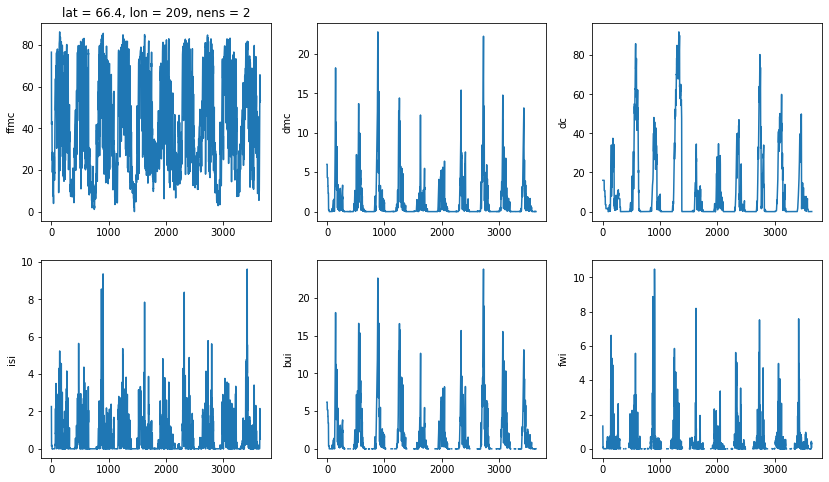

In [49]:
plt.figure(figsize=[14, 8])
for i in range(len(FWIvars)):
    plt.subplot(2, 3, (i + 1))
    if i == 0:
        plt.title('lat = ' + str(plat) + ', lon = ' + str(plon) + ', nens = ' + str(nens))
    plt.plot(tempDS[FWIvars[i]])
    #plt.plot(tempSSP[FWIvars[i]], alpha=0.7)
    plt.ylabel(FWIvars[i]);

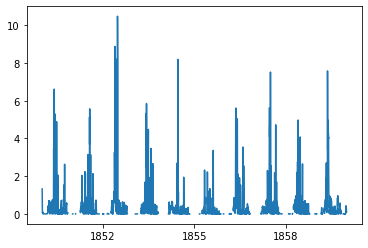

In [50]:
plt.plot(tempDS.time, tempDS['fwi'])
# plt.plot(tempSSP['fwi'])

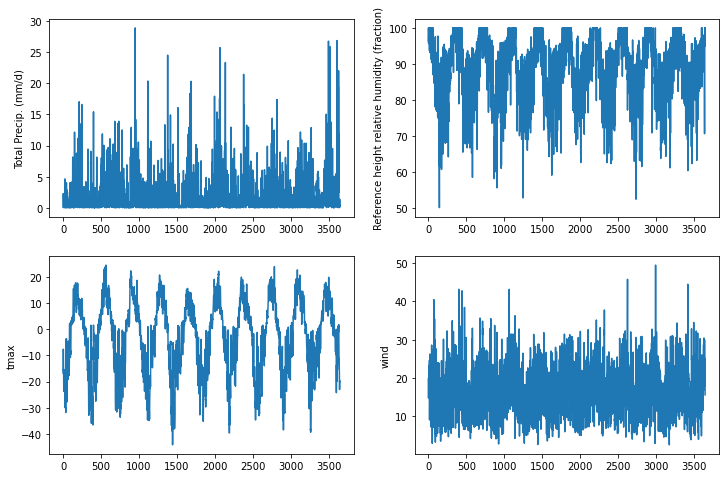

In [52]:
atmVARS = ['PPT', 'RHREFHT', 'tmax', 'wind']
plt.figure(figsize=[12, 8])

for i in range(len(atmVARS)):
    plt.subplot(2, 2, (i + 1))
    plt.plot(tempDS[atmVARS[i]])
    if i < 2:
        plt.ylabel(
            tempDS[atmVARS[i]].attrs['long_name'] + ' (' + tempDS[atmVARS[i]].attrs['units'] + ')'
        )
    else:
        plt.ylabel(atmVARS[i]);

In [27]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark --updated --date --iversions --gitrepo --gitbranch --githash --python

Last updated: 2021-03-16

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.21.0

Git hash: 2b4d0fd526c6400b033bdc942c1d2634239055b5

Git repo: git@github.com:dcherian/cesm-lens.git

Git branch: main

cartopy   : 0.18.0
numpy     : 1.20.1
cftime    : 1.4.1
scipy     : 1.6.0
dask      : 2021.3.0
pandas    : 1.2.3
matplotlib: 3.3.4
xarray    : 0.16.2
numba     : 0.53.0

